In [2]:
from __future__ import annotations
import os
import numpy as np
import torch
import time
from pytomography.io.SPECT import dicom
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform, CutOffTransform
from pytomography.algorithms import OSEMBSR
from pytomography.projectors import SPECTSystemMatrix
from pytomography.priors import TopNAnatomyNeighbourWeight, RelativeDifferencePrior
from pytomography.callbacks import CallBack
import numpy.linalg as npl
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from torchmetrics.image import StructuralSimilarityIndexMeasure
import pydicom

Change this to where you saved the data

In [3]:
datapath = '/disk1/pytomography_paper_data/'

Change this to where you would like to save output

In [4]:
savepath = '/disk1/pytomography_paper_results/data/deepblue_recons'

Open data

In [7]:
path = os.path.join(datapath, 'dicom/deepblue_proj')
files_NM = [os.path.join(path, 'scan1/C2S1D0-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074954.775.11.dcm'),
            os.path.join(path, 'scan2/C2S2D1-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074962.704.2214.dcm'),
            os.path.join(path, 'scan3/C2S3D4-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074961.612.1997.dcm'),
            os.path.join(path, 'scan4/C2S4D5-SPECT-Projections/2.16.840.1.114362.1.11979141.22403444876.563074960.959.1972.dcm')]
path = os.path.join(datapath, 'dicom/deepblue_recon')
paths_CT = [os.path.join(path, 'scan1/ct'),
            os.path.join(path, 'scan2/ct'),
            os.path.join(path, 'scan3/ct'),
            os.path.join(path, 'scan4/ct')]
filess_CT = [[os.path.join(path_CT, file) for file in os.listdir(path_CT)] for path_CT in paths_CT]

Go to "Plotting" if reconstructions already done

# Reconstructing

In [5]:
object_meta, proj_meta = dicom.get_metadata(files_NM[0])
photopeak = dicom.get_projections(files_NM[0], index_peak=0)
scatter = dicom.get_scatter_from_TEW(files_NM[0], index_peak=0, index_lower=1, index_upper=2)

Returned projections have dimensions (1 Ltheta Lr Lz)


In [6]:
attenuation_map_from_CT_slices = dicom.get_attenuation_map_from_CT_slices(filess_CT[0], files_NM[0], index_peak=0, keep_as_HU=True)

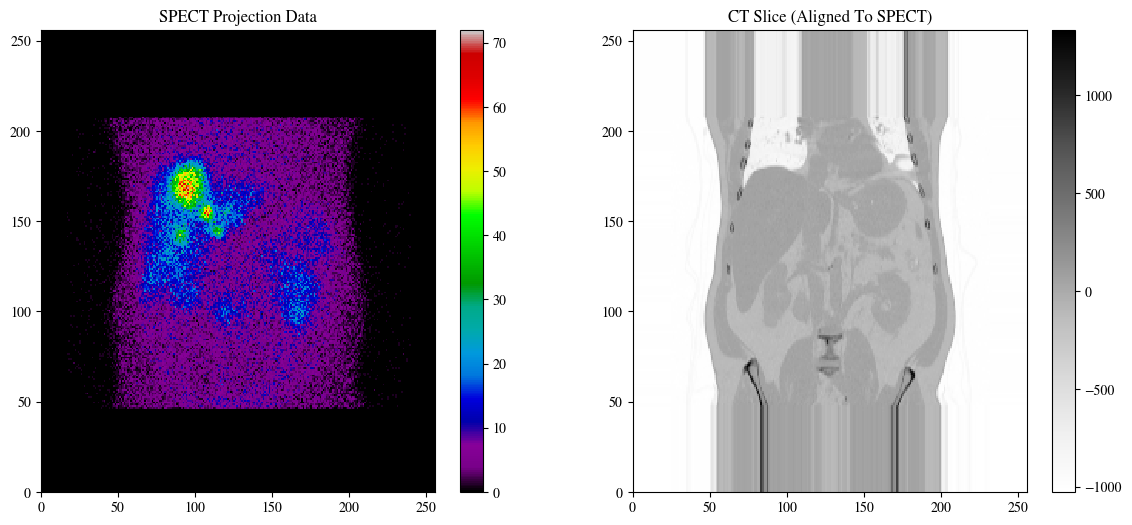

In [7]:
plt.subplots(1,2,figsize=(14,6))
plt.subplot(121)
plt.title('SPECT Projection Data')
plt.pcolormesh(photopeak.cpu()[0,0].T, cmap='nipy_spectral')
plt.colorbar()
plt.subplot(122)
plt.title('CT Slice (Aligned To SPECT)')
plt.pcolormesh(attenuation_map_from_CT_slices[0][:,128].cpu().T, cmap='Greys')
plt.colorbar()

Kidney mask and callback
* Kidney segmentations obtained by using wholebodyCT segmentation model from MONAI

In [8]:
def load_mask(i):
    mask = np.load(os.path.join(datapath, 'dicom/deepblue_masks/' f'deepbluepatient4scan{i+1}.npy'))
    # Left kidney only
    mask = (mask==3).astype(np.float32)
    M_CT = dicom._get_affine_CT(filess_CT[i])
    M_NM = dicom._get_affine_spect_projections(files_NM[i])
    M = npl.inv(M_CT) @ M_NM
    ds_NM = pydicom.read_file(files_NM[i])
    mask = dicom.affine_transform(mask, M, output_shape=(ds_NM.Rows, ds_NM.Rows, ds_NM.Columns), mode='constant', cval=0, order=1)
    mask = mask>=1
    return mask

class SaveData(CallBack):
    def __init__(self, kidney_mask):
        self.kidney_mask = kidney_mask
        self.activities = []
        self.n_subset_save = 7
        
    def run(self, object, n_iter):
        self.activities.append(object[0].cpu().numpy()[self.kidney_mask].mean())

Reconstruction

In [9]:
def reconstruct_singlebed(i, n_iters=5, prior=None, prior_weight=False, callback=None):
    file_NM = files_NM[i]
    files_CT = filess_CT[i]
    object_meta, proj_meta = dicom.get_metadata(file_NM)
    photopeak = dicom.get_projections(file_NM, index_peak=0)
    scatter = dicom.get_scatter_from_TEW(file_NM, index_peak=0, index_lower=1, index_upper=2)
    attenuation_map_from_CT_slices = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=0)
    if prior:
        if prior_weight:
            prior_weight = TopNAnatomyNeighbourWeight(attenuation_map_from_CT_slices, 8)       
            prior = RelativeDifferencePrior(beta=0.3, gamma=3, weight=prior_weight)
        else:
            prior = RelativeDifferencePrior(beta=0.3, gamma=3)
    psf_meta = dicom.get_psfmeta_from_scanner_params('SY-ME', energy_keV=208, min_sigmas=3)
    att_transform = SPECTAttenuationTransform(filepath=files_CT)
    psf_transform = SPECTPSFTransform(psf_meta)
    cutoff_transform = CutOffTransform(photopeak)
    object_initial = cutoff_transform.forward(torch.ones((1,*object_meta.shape)))
    # Create system matrix
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [cutoff_transform],
        object_meta = object_meta,
        proj_meta = proj_meta,
        n_parallel=5)
    # Initialize reconstruction algorithm
    reconstruction_algorithm = OSEMBSR(
        projections = photopeak,
        system_matrix = system_matrix,
        scatter=scatter,
        object_initial = object_initial,
        prior=prior)
    # Reconstruct object
    t_start = time.time()
    reconstructed_object = reconstruction_algorithm(n_iters=n_iters, n_subsets=8, callback=callback)[0].cpu().numpy()
    t_elapsed = time.time() - t_start
    if prior is None:
        prior_name = 'noprior'
    else:
        if prior_weight:
            prior_name = 'prior'
        else:
            prior_name = 'prioreucweight'
    np.save(file=os.path.join(savepath, f'patient4_bed{i+1}_{prior_name}_{n_iters}it_object'), arr=reconstructed_object)
    if callback is not None:
        np.savez(os.path.join(savepath, f'patient4_bed{i+1}_{prior_name}_{n_iters}it'), t_elapsed=t_elapsed, activities=callback.activities)

Reconstruction using prior

In [10]:
for i in range(4):
    callback = SaveData(load_mask(i))
    reconstruct_singlebed(i, n_iters=30, prior=True, prior_weight=True, callback=callback)

Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1415.5 HU
Effective CT Energy Determined: 76.0713410004909 keV
Cortical Bone Peak: 1415.5 HU
Effective CT Energy Determined: 76.0713410004909 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1464.25 HU
Effective CT Energy Determined: 73.9767794194872 keV
Cortical Bone Peak: 1464.25 HU
Effective CT Energy Determined: 73.9767794194872 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1418.800048828125 HU
Effective CT Energy Determined: 75.92025414328496 keV
Cortical Bone Peak: 1418.800048828125 HU
Effective CT Energy Determined: 75.92025414328496 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1417.1500244140625 HU
Effective CT Energy Determined: 75.99582344180563 keV
Cortical Bone Peak: 1417.1500244140625 HU
Effective CT Energy Determined: 75.99582344180563 keV


In [11]:
for i in range(4):
    callback = SaveData(load_mask(i))
    reconstruct_singlebed(i, n_iters=30, prior=True, prior_weight=False, callback=callback)

Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1415.5 HU
Effective CT Energy Determined: 76.0713410004909 keV
Cortical Bone Peak: 1415.5 HU
Effective CT Energy Determined: 76.0713410004909 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1464.25 HU
Effective CT Energy Determined: 73.9767794194872 keV
Cortical Bone Peak: 1464.25 HU
Effective CT Energy Determined: 73.9767794194872 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1418.800048828125 HU
Effective CT Energy Determined: 75.92025414328496 keV
Cortical Bone Peak: 1418.800048828125 HU
Effective CT Energy Determined: 75.92025414328496 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1417.1500244140625 HU
Effective CT Energy Determined: 75.99582344180563 keV
Cortical Bone Peak: 1417.1500244140625 HU
Effective CT Energy Determined: 75.99582344180563 keV


Reconstruction without prior

In [12]:
for i in range(4):
    callback = SaveData(load_mask(i))
    reconstruct_singlebed(i, n_iters=30, callback=callback)

Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1415.5 HU
Effective CT Energy Determined: 76.0713410004909 keV
Cortical Bone Peak: 1415.5 HU
Effective CT Energy Determined: 76.0713410004909 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1464.25 HU
Effective CT Energy Determined: 73.9767794194872 keV
Cortical Bone Peak: 1464.25 HU
Effective CT Energy Determined: 73.9767794194872 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1418.800048828125 HU
Effective CT Energy Determined: 75.92025414328496 keV
Cortical Bone Peak: 1418.800048828125 HU
Effective CT Energy Determined: 75.92025414328496 keV
Returned projections have dimensions (1 Ltheta Lr Lz)
Cortical Bone Peak: 1417.1500244140625 HU
Effective CT Energy Determined: 75.99582344180563 keV
Cortical Bone Peak: 1417.1500244140625 HU
Effective CT Energy Determined: 75.99582344180563 keV


# Plotting

In [8]:
recons_noprior = []
recons_prior = []
recons_prior_w = []
stats_noprior = []
stats_prior = []
for i in range(4):
    recons_noprior.append(np.load(os.path.join(savepath, f'patient4_bed{i+1}_noprior_30it_object.npy')))
    recons_prior.append(np.load(os.path.join(savepath, f'patient4_bed{i+1}_prioreucweight_30it_object.npy')))
    recons_prior_w.append(np.load(os.path.join(savepath, f'patient4_bed{i+1}_prior_30it_object.npy')))
    stats_noprior.append(np.load(os.path.join(savepath, f'patient4_bed{i+1}_noprior_30it.npz'))['activities'])
    stats_prior.append(np.load(os.path.join(savepath, f'patient4_bed{i+1}_prior_30it.npz'))['activities'])    

In [9]:
arrs = [dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM) for (files_CT, file_NM) in zip(filess_CT, files_NM)]

Cortical Bone Peak: 1415.5 HU
Effective CT Energy Determined: 76.0713410004909 keV
Cortical Bone Peak: 1464.25 HU
Effective CT Energy Determined: 73.9767794194872 keV
Cortical Bone Peak: 1418.800048828125 HU
Effective CT Energy Determined: 75.92025414328496 keV
Cortical Bone Peak: 1417.1500244140625 HU
Effective CT Energy Determined: 75.99582344180563 keV


In [10]:
def cmap_f(x,a):
    return (1-np.exp(-x/a))/(1+np.exp(-x/a))

In [11]:
existing_cmap = plt.cm.plasma
# Create a new colormap based on the existing one
colors = existing_cmap(np.linspace(0, 1, 256))
x = np.linspace(0,1,256)
colors[:, -1] = 0.8*cmap_f(x, 5e-2)
new_cmap = mcolors.LinearSegmentedColormap.from_list('NewColormap', colors)

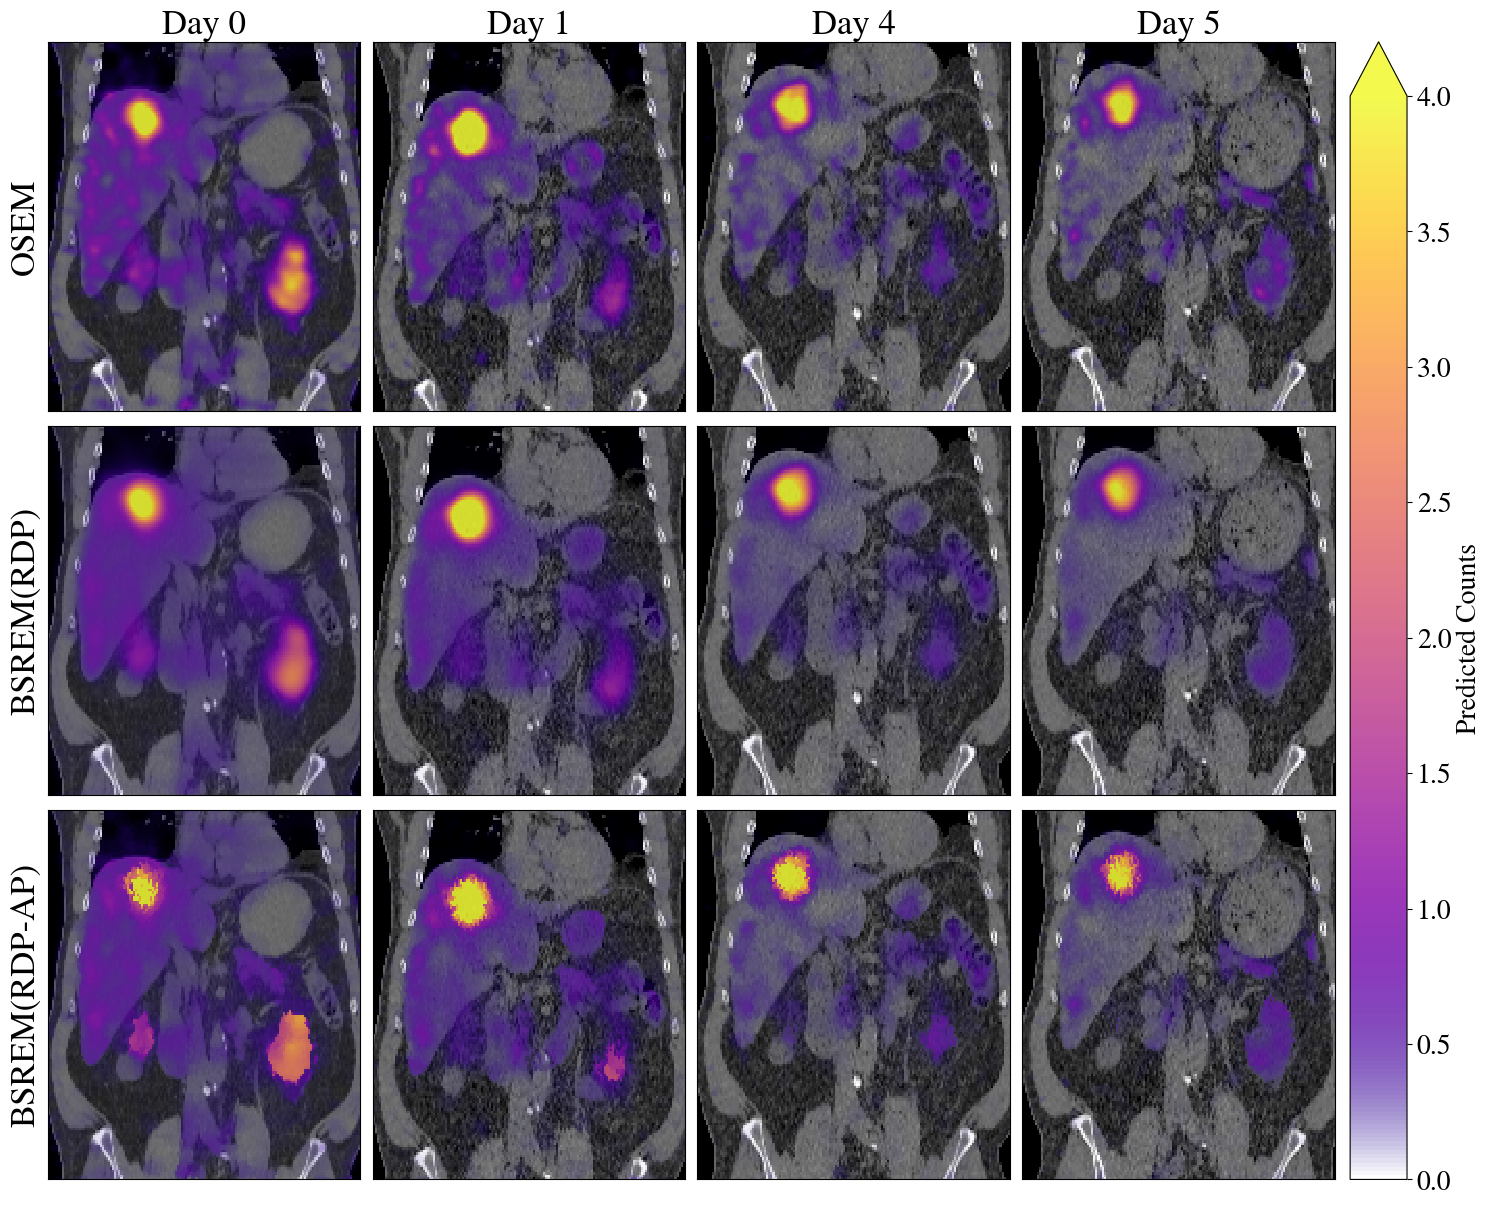

In [23]:
times = ['Day 0', 'Day 1', 'Day 4', 'Day 5']
slcs = np.array([64,64,64,64])*2 -4
body = 1
fig, ax = plt.subplots(3,4,figsize=(16,12))
for i in range(4):
    ax[0,i].pcolormesh(arrs[i].cpu().numpy()[0,:,slcs[i]].T, cmap='Greys_r', vmin=0.106, vmax=0.2)
    im = ax[0,i].pcolormesh(recons_noprior[i][:,slcs[i]].T, cmap=new_cmap, vmax=4)
    ax[0,i].set_xlim(50,200)
    ax[0,i].set_ylim(50,200)
    ax[0,i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[0,i].set_title(times[i], fontsize=25)
for i in range(4):
    ax[1,i].pcolormesh(arrs[i].cpu().numpy()[0,:,slcs[i]].T, cmap='Greys_r', vmin=0.106, vmax=0.2)
    im = ax[1,i].pcolormesh(recons_prior[i][:,slcs[i]].T, cmap=new_cmap, vmax=4)
    ax[1,i].set_xlim(50,200)
    ax[1,i].set_ylim(50,200)
    ax[1,i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for i in range(4):
    ax[2,i].pcolormesh(arrs[i].cpu().numpy()[0,:,slcs[i]].T, cmap='Greys_r', vmin=0.106, vmax=0.2)
    im = ax[2,i].pcolormesh(recons_prior_w[i][:,slcs[i]].T, cmap=new_cmap, vmax=4)
    ax[2,i].set_xlim(50,200)
    ax[2,i].set_ylim(50,200)
    ax[2,i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax[0,0].set_ylabel('OSEM', fontsize=25)
ax[1,0].set_ylabel('BSREM(RDP)', fontsize=25)
ax[2,0].set_ylabel('BSREM(RDP-AP)', fontsize=25)

fig.tight_layout()
cbar = fig.colorbar(im, ax=ax, location='right', extend='max', pad=0.01)
cbar.set_label('Predicted Counts', size=20)
cbar.ax.tick_params(labelsize=20) 
#fig.tight_layout()
plt.savefig('images/figure6_part1.jpg', dpi=300, bbox_inches='tight')

Load masks to plot dose volume histograms
* Masks obtained from MONAI's wholebody CT model

In [16]:
object_meta, proj_meta = dicom.get_metadata(files_NM[0])

In [17]:
def load_mask(i, organ_idx):
    mask_all = np.load(os.path.join(datapath, 'dicom/deepblue_masks/' f'deepbluepatient4scan{i+1}.npy'))
    if type(organ_idx) is int:
        mask = (mask_all==organ_idx).astype(np.float32)
    else:
        mask = np.zeros(mask_all.shape)
        for organ_i in organ_idx:
            mask+=(mask_all==organ_i)
        mask = mask.astype(np.float32)
    ds_NM = pydicom.read_file(files_NM[i])
    M_CT = dicom._get_affine_CT(filess_CT[i])
    M_NM = dicom._get_affine_spect_projections(files_NM[i])
    M = npl.inv(M_CT) @ M_NM
    mask = dicom.affine_transform(mask, M, output_shape=(ds_NM.Rows, ds_NM.Rows, ds_NM.Columns), mode='constant', cval=0, order=1)
    mask = mask>=1
    return mask

In [18]:
def compute_DVH(i, recons, organ_idx):
    r = recons[i] / np.prod(object_meta.dr) #counts/mL
    mask = load_mask(i, organ_idx)
    N, bin_edges = np.histogram(r[mask], bins=100)
    N = np.insert(N, 0 ,0) #0 counts <= 0 dose
    N_rev_cumsum = np.cumsum(N[::-1])[::-1]
    N_rev_cumsum =   N_rev_cumsum / np.max(N_rev_cumsum) * 100
    return bin_edges, N_rev_cumsum

In [19]:
DVH_noprior_dict = {}
for i in range(4):
    DVH_noprior_dict[i] = {}
    for j, mask_idx in enumerate([[2,3],5]):
        DVH_noprior_dict[i][j] = compute_DVH(i, recons_noprior, mask_idx)
DVH_prior_dict = {}
for i in range(4):
    DVH_prior_dict[i] = {}
    for j, mask_idx in enumerate([[2,3],5]):
        DVH_prior_dict[i][j] = compute_DVH(i, recons_prior, mask_idx)
DVH_priorw_dict = {}
for i in range(4):
    DVH_priorw_dict[i] = {}
    for j, mask_idx in enumerate([[2,3],5]):
        DVH_priorw_dict[i][j] = compute_DVH(i, recons_prior_w, mask_idx)

In [20]:
def plot_DVH(axes, i, xlim, title):
    ax = axes[i]
    ax.plot(*DVH_noprior_dict[i][0], color='b')
    ax.plot(*DVH_prior_dict[i][0], color='b', ls='--')
    ax.plot(*DVH_priorw_dict[i][0], color='b', ls=':', lw=2)
    ax.plot(*DVH_noprior_dict[i][1], color='r')
    ax.plot(*DVH_prior_dict[i][1], color='r', ls='--')
    ax.plot(*DVH_priorw_dict[i][1], color='r', ls=':', lw=2)
    ax.set_xlim(0,xlim)
    ax.set_ylim(bottom=0)
    ax.grid()
    ax.set_title(title, fontsize=16)
    
legend_items = [
    Line2D([], [], linestyle='-', color='black', label='OSEM'),
    Line2D([], [], linestyle='--', color='black', label='BSREM(RDP)'),
    Line2D([], [], linestyle=':', color='black', label='BSREM(RDP-AP)'),
    Patch(color='red', label='Liver'),
    Patch(color='blue', label='Kidneys')
]

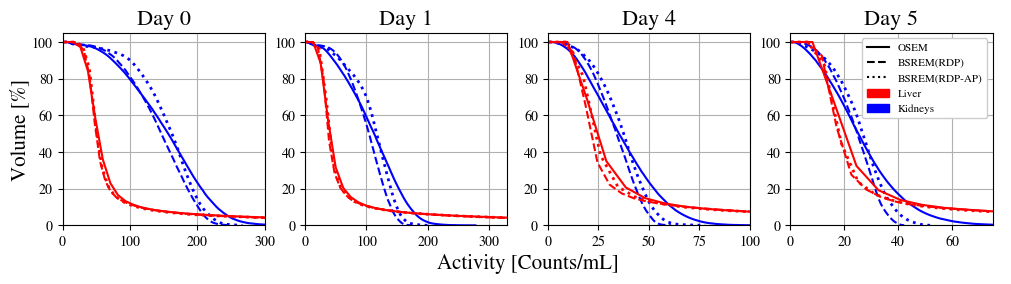

In [22]:
fig, axes = plt.subplots(1,4,figsize=(12,2.5))
plot_DVH(axes, 0, xlim=300, title='Day 0')
plot_DVH(axes, 1, xlim=330, title='Day 1')
plot_DVH(axes, 2, xlim=100, title='Day 4')
plot_DVH(axes, 3, xlim=75, title='Day 5')
axes[-1].legend(handles=legend_items, fontsize=8, facecolor='white', framealpha=1, frameon=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Activity [Counts/mL]", fontsize=15)
plt.ylabel("Volume [%]", fontsize=15)
plt.savefig('images/figure6_part2.pdf', bbox_inches='tight')

In [27]:
t_idx = 3
organ_idx = 0
A1, V1 = DVH_noprior_dict[t_idx][organ_idx]
A2, V2 = DVH_prior_dict[t_idx][organ_idx]
A3, V3 = DVH_priorw_dict[t_idx][organ_idx]

In [28]:
D1 = A1[V1<=0.05][0]
D1

89.52818

In [29]:
D2 = A2[V2<=0.05][0]
D2

42.213528

In [30]:
D3 = A3[V3<=0.05][0]
D3

51.814365

In [31]:
2*(D1-D3)/(D1+D3) * 100

53.36513180089657

In [32]:
t_idx = 0
kidney_mask = load_mask(t_idx, [2,3])
print(recons_noprior[t_idx][kidney_mask].mean()/ np.prod(object_meta.dr))
print(recons_prior[t_idx][kidney_mask].mean()/ np.prod(object_meta.dr))
print(recons_prior_w[t_idx][kidney_mask].mean()/ np.prod(object_meta.dr))

150.3809275692229
140.73662600732874
153.4305079284167


In [33]:
def compute_rmse(r1, r2):
    return np.sqrt(((r1-r2) ** 2).mean())

In [34]:
def compute_ssim(r1, r2):
    r1 = torch.tensor(r1).unsqueeze(0).unsqueeze(0).to('cpu')
    r2 = torch.tensor(r2).unsqueeze(0).unsqueeze(0).to('cpu')
    ssim = StructuralSimilarityIndexMeasure()
    return ssim(r1,r2).item()

In [35]:
for i in range(4):
    print(compute_rmse(recons_noprior[i], recons_prior[i]))
for i in range(4):
    print(compute_ssim(recons_noprior[i], recons_prior[i]))

0.049991462
0.04800226
0.03164867
0.028073795
0.9942077398300171
0.9964451789855957
0.9970878958702087
0.9964799284934998
